<a href="https://colab.research.google.com/github/IshratJahan1623/Intro-to-Machine-Learning/blob/main/Homework_7/HW7_2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda


100%|██████████| 170M/170M [00:03<00:00, 47.8MB/s]



 Weight Decay (lambda=0.001) 
Model parameters: 94058
2025-12-02 20:05:19.814061  Epoch   1/300 | Train Loss: 1.8429  Val Loss: 1.6544 | Train Acc: 0.3188  Val Acc: 0.3747
2025-12-02 20:05:34.772858  Epoch   2/300 | Train Loss: 1.4745  Val Loss: 1.5671 | Train Acc: 0.4522  Val Acc: 0.4414
2025-12-02 20:05:49.962642  Epoch   3/300 | Train Loss: 1.3073  Val Loss: 1.3374 | Train Acc: 0.5205  Val Acc: 0.5087
2025-12-02 20:06:06.248118  Epoch   4/300 | Train Loss: 1.1887  Val Loss: 1.4219 | Train Acc: 0.5682  Val Acc: 0.5074
2025-12-02 20:06:21.711210  Epoch   5/300 | Train Loss: 1.0943  Val Loss: 1.3204 | Train Acc: 0.6058  Val Acc: 0.5068
2025-12-02 20:06:37.082494  Epoch   6/300 | Train Loss: 1.0134  Val Loss: 1.2069 | Train Acc: 0.6344  Val Acc: 0.5792
2025-12-02 20:06:52.424491  Epoch   7/300 | Train Loss: 0.9532  Val Loss: 1.4892 | Train Acc: 0.6566  Val Acc: 0.5017
2025-12-02 20:07:07.619675  Epoch   8/300 | Train Loss: 0.8991  Val Loss: 0.9454 | Train Acc: 0.6768  Val Acc: 0.6650
2

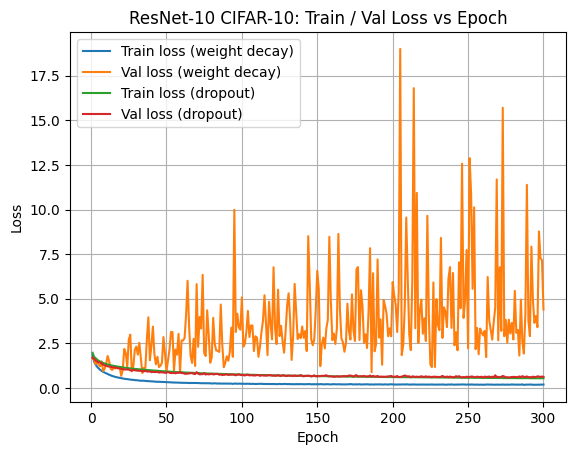

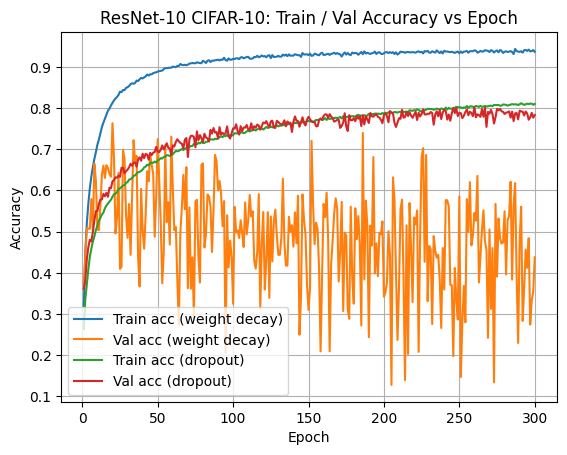


 Summary comparison after training

weight_decay:
  Time (s):          4788.09
  Train loss:        0.1859
  Val loss:          4.3954
  Train accuracy:    0.9366
  Val accuracy:      0.4377
  Model parameters:  94058

dropout:
  Time (s):          4861.59
  Train loss:        0.5406
  Val loss:          0.6176
  Train accuracy:    0.8100
  Val accuracy:      0.7833
  Model parameters:  94058


In [ ]:
import time
import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt



# 1. Device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



# 2. CIFAR-10 Data

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    ),
])

trainset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform,
)
testset = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transform,
)

train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2
)
val_loader = torch.utils.data.DataLoader(
    testset, batch_size=128, shuffle=False, num_workers=2
)



# 3. Building blocks

class ResBlock(nn.Module):
    """Residual block with Conv + BN + ReLU + skip connection."""
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(
            n_chans, n_chans,
            kernel_size=3, padding=1, bias=False
        )
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)

        torch.nn.init.kaiming_normal_(self.conv.weight,
                                      nonlinearity="relu")
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = F.relu(out)
        return out + x


class ResBlockDropout(nn.Module):
    """Residual block with Conv + BN + ReLU + Dropout2d + skip."""
    def __init__(self, n_chans, p=0.3):
        super(ResBlockDropout, self).__init__()
        self.conv = nn.Conv2d(
            n_chans, n_chans,
            kernel_size=3, padding=1, bias=False
        )
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        self.dropout = nn.Dropout2d(p=p)

        torch.nn.init.kaiming_normal_(self.conv.weight,
                                      nonlinearity="relu")
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = F.relu(out)
        out = self.dropout(out)   # dropout after activation
        return out + x


class ResNet10(nn.Module):
    """ResNet-10 for CIFAR-10, using a given block type."""
    def __init__(self, block_cls, n_chans=32, n_blocks=10, n_classes=10,
                 dropout_p=0.3):
        super().__init__()
        self.n_chans = n_chans

        self.conv_in = nn.Conv2d(
            3, n_chans, kernel_size=3, padding=1, bias=False
        )
        self.bn_in = nn.BatchNorm2d(n_chans)
        torch.nn.init.kaiming_normal_(self.conv_in.weight,
                                      nonlinearity="relu")

        # stack of residual blocks
        if block_cls is ResBlockDropout:
            blocks = [block_cls(n_chans, p=dropout_p) for _ in range(n_blocks)]
        else:
            blocks = [block_cls(n_chans) for _ in range(n_blocks)]
        self.blocks = nn.Sequential(*blocks)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(n_chans, n_classes)

    def forward(self, x):
        out = self.conv_in(x)
        out = self.bn_in(out)
        out = F.relu(out)
        out = F.max_pool2d(out, 2)  # 32x32 -> 16x16

        out = self.blocks(out)      # residual stack

        out = self.global_pool(out)  # 16x16 -> 1x1
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out



# 4. Training / evaluation utilities

criterion = nn.CrossEntropyLoss()


def run_epoch(model, loader, optimizer=None):
    """
    If optimizer is provided -> training mode, otherwise eval mode.
    Returns (avg_loss, accuracy).
    """
    if optimizer is None:
        model.eval()
        torch.set_grad_enabled(False)
    else:
        model.train()
        torch.set_grad_enabled(True)

    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        if optimizer is not None:
            optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        if optimizer is not None:
            loss.backward()
            optimizer.step()

        batch_size = targets.size(0)
        running_loss += loss.item() * batch_size
        _, preds = outputs.max(1)
        correct += preds.eq(targets).sum().item()
        total += batch_size

    avg_loss = running_loss / total
    accuracy = correct / total

    torch.set_grad_enabled(True)
    return avg_loss, accuracy


def train_resnet(setting_name, model_fn, optimizer_fn, n_epochs=300):
    """
    Trains a given model/optimizer config and logs metrics.
    Returns histories and summary.
    """
    print(f"\n {setting_name} ")
    model = model_fn().to(device)
    num_params = sum(p.numel() for p in model.parameters())
    print(f"Model parameters: {num_params}")

    optimizer = optimizer_fn(model.parameters())

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    start_time = time.time()
    for epoch in range(1, n_epochs + 1):
        train_loss, train_acc = run_epoch(model, train_loader, optimizer)
        val_loss, val_acc = run_epoch(model, val_loader, optimizer=None)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(
            f"{datetime.datetime.now()}  "
            f"Epoch {epoch:3d}/{n_epochs} | "
            f"Train Loss: {train_loss:.4f}  Val Loss: {val_loss:.4f} | "
            f"Train Acc: {train_acc:.4f}  Val Acc: {val_acc:.4f}"
        )

    total_time = time.time() - start_time
    print(f"\n>>> {setting_name} finished.")
    print(f"Training time: {total_time:.2f} seconds")
    print(f"Final Train Loss: {train_losses[-1]:.4f}")
    print(f"Final Val   Loss: {val_losses[-1]:.4f}")
    print(f"Final Train Acc : {train_accs[-1]:.4f}")
    print(f"Final Val   Acc : {val_accs[-1]:.4f}")

    summary = {
        "time": total_time,
        "final_train_loss": train_losses[-1],
        "final_val_loss": val_losses[-1],
        "final_train_acc": train_accs[-1],
        "final_val_acc": val_accs[-1],
        "num_params": num_params,
    }
    return train_losses, val_losses, train_accs, val_accs, summary



# 5. Two trainings: weight decay, dropout

n_epochs = 300
histories = {}
summaries = {}

# (1) Weight decay (L2) with lambda = 0.001
histories["weight_decay"] = train_resnet(
    "Weight Decay (lambda=0.001)",
    model_fn=lambda: ResNet10(ResBlock, n_chans=32, n_blocks=10, n_classes=10),
    optimizer_fn=lambda params: optim.SGD(
        params, lr=0.01, momentum=0.9, weight_decay=0.001
    ),
    n_epochs=n_epochs,
)
summaries["weight_decay"] = histories["weight_decay"][-1]

# (2) Dropout with p = 0.3
histories["dropout"] = train_resnet(
    "Dropout (p=0.3)",
    model_fn=lambda: ResNet10(
        ResBlockDropout, n_chans=32, n_blocks=10,
        n_classes=10, dropout_p=0.3
    ),
    optimizer_fn=lambda params: optim.SGD(params, lr=0.01, momentum=0.9),
    n_epochs=n_epochs,
)
summaries["dropout"] = histories["dropout"][-1]



# 6. Plotting: loss & accuracy vs epoch

epochs = range(1, n_epochs + 1)

# Unpack histories for easier plotting
def unpack(h):
    train_losses, val_losses, train_accs, val_accs, _summary = h
    return train_losses, val_losses, train_accs, val_accs

(wd_tr_l, wd_val_l, wd_tr_a, wd_val_a) = unpack(histories["weight_decay"])
(dp_tr_l, dp_val_l, dp_tr_a, dp_val_a) = unpack(histories["dropout"])

plt.figure()
plt.plot(epochs, wd_tr_l, label="Train loss (weight decay)")
plt.plot(epochs, wd_val_l, label="Val loss (weight decay)")
plt.plot(epochs, dp_tr_l, label="Train loss (dropout)")
plt.plot(epochs, dp_val_l, label="Val loss (dropout)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ResNet-10 CIFAR-10: Train / Val Loss vs Epoch")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(epochs, wd_tr_a, label="Train acc (weight decay)")
plt.plot(epochs, wd_val_a, label="Val acc (weight decay)")
plt.plot(epochs, dp_tr_a, label="Train acc (dropout)")
plt.plot(epochs, dp_val_a, label="Val acc (dropout)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("ResNet-10 CIFAR-10: Train / Val Accuracy vs Epoch")
plt.legend()
plt.grid(True)
plt.show()

# Summary comparison
print("\n Summary comparison after training")
for name, s in summaries.items():
    print(f"\n{name}:")
    print(f"  Time (s):          {s['time']:.2f}")
    print(f"  Train loss:        {s['final_train_loss']:.4f}")
    print(f"  Val loss:          {s['final_val_loss']:.4f}")
    print(f"  Train accuracy:    {s['final_train_acc']:.4f}")
    print(f"  Val accuracy:      {s['final_val_acc']:.4f}")
    print(f"  Model parameters:  {s['num_params']}")
